# OpenAI Gym env: `CartPole-v0`
### An Intelligent agent with Q-learning


## The Imports

In [13]:
#!setopt no_nomatch
#!pip install gym[pong]

zsh:1: no matches found: gym[pong]


In [1]:
import gym
import math
import imageio.v2 as imageio
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import load, dump

## Making of an Intelligent CartPole-v0 agent
![CartPole-v0-Qlearning](../video/CartPole-v0-QLearning.gif)

![elements of Reinforcement Learning](figs/elements-RL.png)

![Agent-environment loop](figs/elements-RL-1.png)

![elements of Reinforcement Learning](figs/elements-RL-2.png)

![principles of Reinforcement Learning](figs/principles-RL-1.png)

![principles of Reinforcement Learning](figs/principles-RL-2.png)

![Q-value](figs/Q_value-1.png)

![Q-value](figs/Q_value-2.png)

In [1]:
#The imports
import gym
import math
import imageio.v2 as imageio
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import load, dump

### Idea 1: Discretizing continuous state space

In [51]:
def discretize_state(state, env, buckets=(1,1,6,12)):
    """    
    The problem: The original states in this game are continuous, which does not work with the basic Q-learning algorithm as it expects discrete states. By the way, a slightly advanced Q-learning strategy can work with continuous state space with the help of approximation. Let's leave that strategy out of the scope of this course! Sorry. please enroll the "AI with Reinforcement Learning" course in Spring'23 with Dr. B. Purpose of this function is to discretize the continuous state space into buckets. 

    :param state: current state's observation which needs discretizing
    :type state: 4-D float array
    :param env: the cartpole environment
    :type env: environment object returned most likely from a gym.make() call.
    :param buckets: this will be used to discretize the original continuous states in this Cartpole example, defaults to (1,1,6,12)
    :type buckets: tuple, optional
    :return: The discretized state space in the given buckets
    :rtype: tuple
    """
    ## [position of cart, velocity of cart, angle of pole, rotation rate of pole]
    ## i) x-coordinate of the pole's center of mass (i.e., cart position), unit: m
    ## ii) Cart velocity [-inf, inf], unit: m/s
    ## iii) the pole's angle to the cart/platform. the pole angle in radians (1 radian = 57.295 degrees); 
    ## iv) the pole's angular velocity [-inf, inf], unit: radian/s
    

    # Revising the upper and the lower bounds for the discretization
    # Please note: cart velocity upper and lower bounds are 3.4e38 (inf), -3.4e38 (-inf). That's a huge space!
    # Let's shrink it down to [0.5, -0.5]

    # Also note: pole's angular velocity upper and lower bounds are 3.4e38 (inf), -3.4e38 (-inf). That's also a huge space!
    # Let's shrink it down to [50 degrees/1 sec, -50 degrees/1 sec]
    
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50) / 1.]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50) / 1.]

    # state is the native state representations produced by env
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    
    # state_ is discretized state representation used for Q-table later
    state_ = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    state_ = [min(buckets[i] - 1, max(0, state_[i])) for i in range(len(state))]

    return tuple(state_) 

### Idea 2: `act` with `Epsilon-greedy policy`

In [52]:
def epsilon_greedy_policy(state, env, Q_table, exploration_rate):
    """This is an epsilon greedy policy. 
    In other words, most of the times the agent chooses the action that maximizes the 
    reward given state (greedily). But occassionally (controlled by the exploration_rate), 
    the agent chooses a random action which makes sure the agent balances between 
    exploitation and exploration

    :param state: the current state the agent is at.
    :type state: same as state
    :param env: the CartPole environment
    :type env: environment type returned perhaps from gym.make() call.
    :param Q_table: a table-like structure
    :type Q_table: same as Q_table
    :param exploration_rate: exploration rate
    :type exploration_rate: a small number close to 0.
    :return: action to be taken in the next step
    :rtype: between any value in the action_space. E.g., {0 (left), 1 (right)}
    """
    if (np.random.random() < exploration_rate):
        # Generates numbers np.random.random() uniformly between 0-1
        # This samples a random action given the environment
        return env.action_space.sample()
    else:
        # Choose greedily the action which gives the highest expected reward
        # given the current state
        return np.argmax(Q_table[state])


### Idea 3: Learning rate decay strategy

In [53]:
def get_rate_with_decay(t, decay_rate=25.0):
    """Get the learning rate or exploration_rate given an episode subject to decay. 
    Given the current episode number and the rate has a tendency to decrease with increasing number of episodes.

    :param t: episode number
    :type t: int
    :param decay_rate: decay rate, defaults to 25%
    :type decay_rate: float
    :return: decayed alpha value
    :rtype: float
    """
    decayed_alpha = max(0.1, min(1., 1. - np.log10((t + 1) / decay_rate)))
    return decayed_alpha

![explore-exploit](figs/explore_exploit.png)

In [54]:
def update_epsilon(current_epsilon, decay_rate=0.99, epsilon_minimum=0.1):
    """Update exploration rate (epsilon) based on a decay rate per episode. 
    
    :param current_epsilon: current value of the exploration rate.
    :type current_epsilon: float
    :param decay_rate: decay rate. Exploration rate decays by this factor every episode.
    :type decay_rate: float, default 0.9
    :param epsilon_minimum: exploration_rate won't go below this set minimum.
    :type epsilon_minimum: float, defaults to 0.1 
    """
    if current_epsilon * decay_rate > epsilon_minimum:
        return current_epsilon * decay_rate
    else:
        return epsilon_minimum

### Idea 4: Update Q-table (for one step)

## Solving Bellman Equation with Dynamic Programming 
![Q-value](figs/Q_value-2.png)

## Temporal Difference Learning (TD ($\lambda=0$))
* Temporal-Difference learning = TD learning
* Learns from partial returns.
* The learned action-value function $Q$ directly approximates the optimal action-value function $Q*$ independent of the policy being followed.
* In update rule, choose action a that maximizes $Q$ given $S_{t+1}$ and use the resulting Q-value (i.e. estimated value given by optimal action-value function) plus the observed reward as the target
* This method is off-policy because we do not have a fixed policy that maps from states to actions. 
* This is why $A_{t+1}$ is not used in the update rule

![TD](figs/TD.png)

In [55]:
def update_Q(Q_table, state, action, reward, new_state, alpha, gamma,strategy_type="DP"):
    """Q-learning update step.

    :param Q_table: a table-like structure with N rows for states and M columns for actions
    :type Q_table: numpy array of shape (shape(discretized_state_space),shape(action_space)). Example: (1,1,6,12,2), where (1,1,6,12) is the shape of discretized state space, and (2,) is the shape of action space.
    :param state: the current state the agent is at time step t.
    :type state: numpy array of shape(discretized_state_space)
    :param action: the action taken given the previous state at time step t
    :type action: int
    :param reward: reward collected as a result of that action at time step t
    :type reward: int
    :param new_state: the new state at time-step t+1
    :type new_state: same as state
    :param alpha: learning rate
    :type alpha: float
    :param gamma: discount factor
    :type gamma: float
    :param strategy_type: Q_table update strategy. Currently supported: {DP, TD_0}
    :type strategy_type: str
    :return: updated Q_table
    :rtype: same shape of the given Q_table
    """
    
    if strategy_type=="DP":
        #Strategy 1: DP
        Q_table[state][action] = Q_table[state][action] + reward + gamma * np.amax(Q_table[new_state])
    elif strategy_type=="TD_0":
        #Strategy 2: Off-policy Temporal Difference (lambda = 0)
        Q_table[state][action] = Q_table[state][action] +                        \
                    alpha * (                                                    \
                                reward + gamma * np.max(Q_table[new_state]) -    \
                                Q_table[state][action]                           \
                            )
    return Q_table

### Idea 5: Q-learning ==> combining all the previous 4 ideas

In [56]:
def Q_learning(env, num_episodes, gamma=0.9,strategy_type="DP"):
    """Training the agent with Q-learning with respect to pseudocode in Algorithm 1

    :param env: the cartpole environment
    :type env: environment object likely returned from a gym.make() call.
    :param num_episodes: the number of episodes for which to train
    :type num_episodes: int
    :param gamma: Discount factor gamma represents how much does the agent value future rewards as opposed to immediate rewards.
    :type gamma: float
    :param strategy_type: Q_table update strategy. Currently supported: {DP, TD_0}
    :type strategy_type: str
    :return: The optimized Q-table
    :rtype: (dim(discretized_state_space)+dim(action_space)), e.g., (1,1,6,12,2) in CartPole-v0
    :return: A list containing the total cummulative reward for each episode of training.
    :rtype: list of length==num_episodes
    """

    # (1, 1, 6, 12) represents the discretization buckets.
    # Initialize the Q-table as full of zeros at the start.
    # Shape of Q_table would be = (1,1,6,12,  2), as there are 2 actions.
    Q_table = np.zeros((1, 1, 6, 12) + (env.action_space.n,))

    # Create a list to store the accumulated reward per each episode
    total_reward = []
    
    #Initially, we set 90% exploration, 10% exploitation
    alpha = exploration_rate = 0.9 
    
    for e in tqdm(range(num_episodes)):

        # Reset the environment for a new episode, get the default state S_0
        state,info = env.reset()
        #convert the continuous state to discrete state
        state = discretize_state(state, env)

        # Adjust the alpha and the exploration rate, it is a coincidence they are the same.
        #alpha = exploration_rate = get_rate_with_decay(e)
        alpha = exploration_rate = update_epsilon(exploration_rate)
        
        # Initialize the current episode reward to 0 
        episode_reward = 0
        done = False
        while done is False:
            # Choose the action A_{t} based on the policy
            action = epsilon_greedy_policy(state, env, Q_table, exploration_rate)

            # Get the new state (S_{t+1}), reward (R_{t+1}), end signal
            new_state, reward, done, _, _ = env.step(action)
            #convert the continuous state to discrete state
            new_state = discretize_state(new_state, env)

            # Update Q-table via update_q(Q_table, S_{t}, A_{t}, R_{t+1}, S_{t+1}, alpha, gamma) 
            Q_table = update_Q(Q_table, state, action, reward, new_state, alpha, gamma,strategy_type="TD_0")

            # Update the state S_{t} = S_{t+1}
            state = new_state
            
            # Accumulate the reward
            episode_reward += reward
        
        total_reward.append(episode_reward)
    print('Finished training!')
    return Q_table, total_reward


## Okay, Let's train the Q-learning agent

In [57]:
#Now, let's begin train
# OpenAI Gym builds the environment for us including all the rules, dynamics etc.
env = gym.make('CartPole-v0',render_mode='rgb_array')

#you can tune verbosity of cell executions
verbose = True

# How long do we want the agent to explore and learn?
num_episodes = 2000

In [58]:
# Let us use Q-learning to learn best policy
Q_table, total_reward = Q_learning(env, num_episodes,gamma=0.98,strategy_type="TD_0")

100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.07it/s]

Finished training!


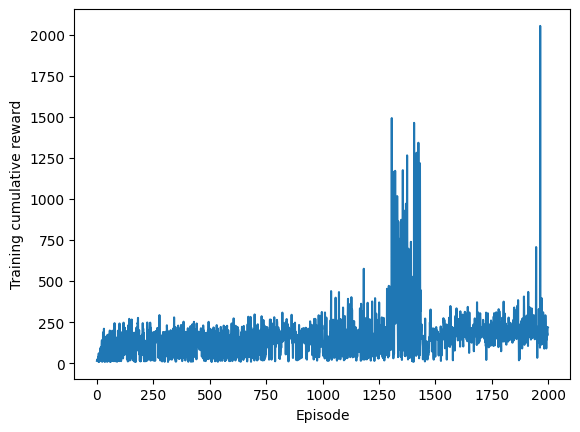

[[[[[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[ 2.70408597  9.64496904]
    [49.00144945  0.        ]
    [49.88874131  4.30861918]
    [49.97626702 24.14109031]
    [49.98859848 41.88358622]
    [49.99153842 49.01711496]
    [49.99139464 48.95335956]
    [48.87825104 49.99428121]
    [49.99207491 40.37530349]
    [13.29533448 49.99031987]
    [ 6.53277451  0.        ]
    [ 3.98219258  0.        ]]

   [[48.40916277 42.11095977]
    [49.9922094  46.96357734]
    [49.99863437 43.44148122]
    [49.99866166 49.89178472]
    [49.99893974 49.99815593]
    [49.99892556 49.99811795]
    [49.99096    49.99893616]
    [49.99486232 49.99891513]
    [49.48134264 49.99868327]
    [4

['joblibs/Q_table.joblib']

In [59]:
if verbose:
    #Plot
    plt.plot(range(num_episodes), total_reward)
    plt.xlabel('Episode')
    plt.ylabel('Training cumulative reward')
    plt.show()

    print(Q_table, Q_table.shape)

#Saving the Q table for later use.
dump(Q_table,'joblibs/Q_table.joblib')

In [60]:
#Don't forget to close the gym environment
env.close()

### Evaluating Q-learning agent after training

#### The imports

In [61]:
import gym
import math
import imageio.v2 as imageio
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import load, dump

In [62]:
#Let's run one episode

max_episode_length = 400 
#Duh! You wish!! It depends on how good your agent learned during training. 



# This way we can test the agent's recently learned policy with the saved Q_table
Q_table = load('joblibs/Q_table.joblib')

In [63]:
##test and visualization!

# Don't forget to switch to render_mode='rgb_array', otherwise env.render() will return None.
env = gym.make('CartPole-v0',render_mode='rgb_array')

In [64]:
# Initialize the reward
episode_reward = 0

# Count how many times the agent went right and how many times it went left
right = 0
left = 0

# Initialize empty buffer for the images that will be stiched to a gif
# Create a temp directory
filenames = []

In [65]:
#Create a temp directory for saving snapshots of environments
try:
    os.mkdir("./temp")
except:
    pass

In [66]:
# Test the trained agent in a completely fresh start environment
state,info = env.reset()
# Don't forget to discretize the state_space the same way you did to train the agent
state = discretize_state(state, env)

In [67]:
# Run for maximum of max_episode_length steps which is the limit of the game
for step in tqdm(range(max_episode_length)):

    # Plot the previous state and save it as an image that 
    # will be later patched together sa a .gif
    img = plt.imshow(env.render())

    plt.title("Step: {}".format(step))
    plt.axis('off')
    plt.savefig("./temp/{}.png".format(step))
    plt.close()
    filenames.append("./temp/{}.png".format(step))
            
    # Here we set the exploration rate to 0.0 as we want to avoid any random exploration.
    # That is, we want the agent fully depends on its learned policy (+Q_table)
    action = epsilon_greedy_policy(state, env, Q_table, exploration_rate=0.0)

    #Just for statistics purpose
    right+=1 if action == 1 else 0
    left+=1 if action == 0 else 0

    #Apply the next step
    new_state, reward, done, _ , _ = env.step(action)
    #Don't forget to discretize new_state
    new_state = discretize_state(new_state, env)
    state = new_state

    #Collect/accumulate reward
    episode_reward += reward

    # At the end of the episode print the total reward, 
    # only the agent is done before the set max_episode_length steps.
    # If your agent was trained well, who knows, the following would never happen! Haha
    if done:
        print(f'Test episode finished at step {step+1} with a total reward of: {episode_reward}')
        print(f'We moved {right} times right and {left} times left')
        break

 55%|██████████████████████▎                  | 218/400 [00:36<00:30,  6.04it/s]

Test episode finished at step 219 with a total reward of: 219.0
We moved 105 times right and 114 times left


In [68]:
# Stitch the images together to produce a .gif
with imageio.get_writer('../video/CartPole-v0-QLearning.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [69]:
# Cleanup the images for the next run
for f in filenames:
    os.remove(f)

In [70]:
# Close the environment
env.close()

![CartPole-v0-Qlearning](../video/CartPole-v0-QLearning.gif)

# Thanks for your attention